In [9]:
import sys

def get_env():
    sp = sys.path[1].split("/")
    if "envs" in sp:
        return sp[sp.index("envs") + 1]
    else:
        return ""

In [10]:
get_env()

'Dispersion'

In [12]:
from glob import glob
from collections import Counter
import re
import os
import pandas as pd
import collections
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import re
from datetime import datetime
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import wordnet
from tqdm.notebook import tqdm, trange
import time
import seaborn as sn
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [ ]:
"""
    Processes a string to extract words and their frequencies.

    Parameters:
        string (str): The input string to be processed.

    Returns:
        A dictionary object containing words as keys and their frequencies as values.

"""
def process_line(string: str):
    result = collections.defaultdict(lambda: 0)
    string = re.sub(r'[^\w\s]', '', string)
    string = re.sub(r'_', ' ', string)
    string = string.lower()
    detected_words = string.split()
    for word in detected_words:
        result[word] += 1
    return result

In [ ]:
"""
    Processes a metadata file to extract relevant metadata using the process_footer function.

    Parameters:
        filepath (str): The path to the metadata file.
        df (DataFrame): The DataFrame to be updated with the extracted metadata.

    Returns:
        DataFrame: The DataFrame updated with the extracted metadata.
"""
def process_file_meta(filepath: str, df):
    with open(filepath, 'r') as file:
        lines = file.readlines()

        footer_found = False
        for line in lines:
            if name == 'Soderstrom':
                if line.startswith('@@@@@@'):
                    footer_found = True
                    break
            elif name == 'Lara':
                if line.startswith('@UTF'):
                    footer_found = True
                    break
                
        if not footer_found:
            raise Exception(f"Could not find footer in file {filepath}")
        coords = process_footer(lines) 
        
    for k in coords:
        df[k] = coords[k]
    return df

In [ ]:
"""
    Extracts metadata from footer lines of a file.

    Parameters:
        lines (list): List of lines from the file footer.

    Returns:
        dict: A dictionary containing extracted metadata.

"""

def process_footer(lines):
    """
    Example strings we want to extract:

    @Time Duration:	15:25-16:00
    @Date:	10-SEP-2003
    @Time Start:	08:00
    @Comment:	time duration 45 minutes

    Sometimes, these show up more than once, or not at all.
    """

    coords = {}
    for line in lines:
        if line.startswith('@Time Duration'):
            field_name = 'time duration'
            field_value = line.split('@Time Duration:')[-1]

        elif line.startswith('@Date:'):
            # Process this line and try turning it into a datetime
            field_name = 'date'
            field_value = line.split('@Date:')[-1]
            field_value = re.sub(r'-', '/', field_value)
            field_value = field_value.lower()
            field_value = field_value.strip()
            
        elif line.startswith('@Time Start:'):
            field_name = 'time start'
            field_value = line.split('@Time Start:')[-1]
            field_value = field_value.strip()

        # Check if the line contains information about the time duration in a different format
        elif 'time duration' in line:   
            field_name = 'duration'
            duration_match = re.search(r"time duration (\d+) minutes", line)
            if duration_match:
                duration = int(duration_match.group(1))
                field_value = duration

        else:
            continue
            
        # Check if the field name already exists in the dictionary
        if field_name in coords:
            print(f'Already found {field_name} in coords. Using first value')
        else:
            coords[field_name] = field_value
            
    #Default values if metadata is not found in footer   
    if 'date' not in coords:
        print("Could not find date")
        coords['date'] = 'unknown'
    if 'time duration' not in coords:
        print("Could not find time duration")
        coords['time duration'] = 'unknown'
    if 'time start' in coords and 'duration' in coords:
        print("Getting timestamp another way")
        # Convert the start time to datetime object
        start_time_dt = pd.to_datetime(coords['time start'], format='%H:%M')

        # Calculate the end time by adding the duration
        end_time_dt = start_time_dt + pd.Timedelta(minutes=coords['duration'])

        # Convert the end time to string format
        end_time = end_time_dt.strftime('%H:%M')
        coords['end time'] = end_time
        
    if 'time start' not in coords:
        coords['time start'] = 'unknown'

    return coords

In [ ]:
"""
    Processes each file to extract words and their number of appearances, then stores the data into a DataFrame with filename.

    Parameters:
        filepath (str): The path to the file to be processed.

    Returns:
        DataFrame: A DataFrame containing the extracted words and their appearances, with an additional column for the filename.
"""
def process_file(filepath: str):
    # key-value pairs into a dictionary of lists
    detected_words = collections.defaultdict(list)
    with open(filepath, 'r') as file:
        lines = file.readlines()

        for line in lines:
            #If footer is found, end process
            if "UTF" in line:
                break
                
            result = process_line(line)
                
            for word in result:
                detected_words['word'].append(word)
                detected_words['nappearances'].append(result[word])

    data_vars = {}
    for k in detected_words:
        data_vars[k] = detected_words[k]

    df = pd.DataFrame(data_vars)
    df['filename'] = os.path.basename(filepath)
    return df

In [14]:
# Set the value of 'name' to either 'Soderstrom' or 'Lara'
name = 'Soderstrom'

filepaths_meta = sorted(glob(f'{name}/Raw_Text/*.txt'))
filepaths_clean = sorted(glob(f'{name}/Cleaned/*.txt'))
dlist = []
for filepath_meta,filepath_clean in zip(filepaths_meta, filepaths_clean):
    # Process the cleaned text file and extract words and their appearances
    df = process_file(filepath_clean)
    # Process the metadata file and update the DataFrame
    df = process_file_meta(filepath_meta,df)
    dlist.append(df)
df_all = pd.concat(dlist)

ValueError: No objects to concatenate

In [22]:
if f'{name}' == "Soderstrom":
    df_all = df_all[(df_all['date'] != 'unknown') & (df_all['time duration'] != 'unknown')]
    df_all['time duration'] = df_all['time duration'].str.strip()

    # Convert the 'date' column to datetime format
    df_all['date'] = pd.to_datetime(df_all['date'], format='%d/%b/%Y')

    # Extract the day of the week and assign it to the 'day_of_week' column
    df_all['day_of_week'] = df_all['date'].dt.strftime('%A')

    # Extract the time portion from 'time duration' column
    df_all['time'] = df_all['time duration'].str.extract(r'(\d{2}:\d{2}-\d{2}:\d{2})')

    # Drop the 'time duration' column
    df_all.drop('time duration', axis=1, inplace=True)
    df_unique = df_all.drop_duplicates(subset=['date', 'time'])[['date', 'time','day_of_week']]
    df_unique.dropna(inplace=True)
    # Convert the 'time' column to start and end times
    df_unique['start_time'], df_unique['end_time'] = df_unique['time'].str.split('-').str
    df_unique['start_time'] = pd.to_datetime(df_unique['start_time'], format='%H:%M')
    df_unique['end_time'] = pd.to_datetime(df_unique['end_time'], format='%H:%M')
    
    df_unique['time_difference_minutes'] = (df_unique['end_time'] - df_unique['start_time']).dt.total_seconds() / 60

    min_value = df_unique['time_difference_minutes'].min()

    # Find the maximum value
    max_value = df_unique['time_difference_minutes'].max()

    # Find the mean value
    mean_value = df_unique['time_difference_minutes'].mean()

    print("Minimum:", min_value)
    print("Maximum:", max_value)
    print("Mean:", mean_value)
    df_unique['start_time'] = df_unique['start_time'].dt.floor('15min')
    df_unique['end_time'] = df_unique['end_time'].dt.floor('15min')
    print(df_unique)
    #day_counts = df_unique['date'].value_counts()
    #print(day_counts)
        
if f'{name}' == "Lara":
    df_all = df_all[(df_all['date'] != 'unknown') & (df_all['time start'] != 'unknown')]
        # Find the minimum value
    min_value = df_all['duration'].min()

    # Find the maximum value
    max_value = df_all['duration'].max()

    # Find the mean value
    mean_value = df_all['duration'].mean()

    print("Minimum:", min_value)
    print("Maximum:", max_value)
    print("Mean:", mean_value)

    # Convert the 'date' column to datetime format
    df_all['date'] = pd.to_datetime(df_all['date'], format='%d/%b/%Y')

    # Extract the day of the week and assign it to the 'day_of_week' column
    df_all['day_of_week'] = df_all['date'].dt.strftime('%A')

    # Drop the 'time duration' column
    df_unique = df_all.drop_duplicates(subset=['date', 'time start'])[['date', 'time start', 'end time', 'day_of_week']]
    df_unique.dropna(inplace=True)
    # Convert the 'time' column to start and end times
    df_unique['time start'] = pd.to_datetime(df_unique['time start'], format='%H:%M')
    df_unique['time start'] = df_unique['time start'].dt.floor('15min')
    df_unique['end time'] = pd.to_datetime(df_unique['end time'], format='%H:%M')
    df_unique['end time'] = df_unique['end time'].dt.floor('15min')
    print(df_unique)
    day_counts = df_unique['day_of_week'].value_counts()
    print(day_counts)

Minimum: 3.0
Maximum: 41.0
Mean: 20.875
        date         time day_of_week          start_time            end_time  \
0 2003-09-09  15:25-16:00     Tuesday 1900-01-01 15:15:00 1900-01-01 16:00:00   
0 2003-09-17  10:18-10:44   Wednesday 1900-01-01 10:15:00 1900-01-01 10:30:00   
0 2003-09-17  10:45-10:53   Wednesday 1900-01-01 10:45:00 1900-01-01 10:45:00   
0 2003-09-23  11:25-11:58     Tuesday 1900-01-01 11:15:00 1900-01-01 11:45:00   
0 2003-09-29  10:31-10:34      Monday 1900-01-01 10:30:00 1900-01-01 10:30:00   
0 2003-10-02  11:45-11:51    Thursday 1900-01-01 11:45:00 1900-01-01 11:45:00   
0 2003-10-02  11:55-12:21    Thursday 1900-01-01 11:45:00 1900-01-01 12:15:00   
0 2003-10-06  11:07-11:34      Monday 1900-01-01 11:00:00 1900-01-01 11:30:00   
0 2003-10-13  17:14-17:43      Monday 1900-01-01 17:00:00 1900-01-01 17:30:00   
0 2003-10-14  10:39-10:47     Tuesday 1900-01-01 10:30:00 1900-01-01 10:45:00   
0 2003-10-20  10:56-11:17      Monday 1900-01-01 10:45:00 1900-01-01 

/var/folders/2b/cx2sl931615g87qtj1jpfdqh0000gn/T/ipykernel_34306/2460849453.py:19: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df_unique['start_time'], df_unique['end_time'] = df_unique['time'].str.split('-').str


In [234]:
# Create a column for count of recording sessions
df_unique['count'] = 1

# Create a list of all possible time intervals in 15-minute increments
time_intervals = pd.date_range('00:00', '23:45', freq='15min').time

# Create an empty matrix with days of the week as rows and time intervals as columns
matrix_result = pd.DataFrame(index=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
                             columns=time_intervals).fillna(0)

# Iterate over each row in the dataset
for _, row in df_unique.iterrows():
    day = row['day_of_week']
    start_time = row['time start']
    end_time = row['end time']
    
    # Find the corresponding time interval indices
    start_index = np.where(time_intervals == start_time.time())[0][0]
    #print(start_index)
    end_index = np.where(time_intervals == end_time.time())[0][0]
    #print(end_index)
    
    # Increment the counts in the matrix for the time intervals within the range
    matrix_result.loc[day, time_intervals[start_index:end_index+1]] += 1

# Display the resulting matrix
matrix_transposed = np.transpose(matrix_result)
with pd.ExcelWriter('HeatMapLara.xlsx') as writer:
    matrix_transposed.to_excel(writer, sheet_name='heatmap')

In [10]:
# %% Turn into the matrix
all_days = (set(df_all['date'].values))
print(all_days)
date_to_i = {d: i for (i, d) in enumerate(all_days)}

all_words = sorted(set(df_all['word'].values))
word_to_j = {w: j for (j, w) in enumerate(all_words)}

N = np.zeros((len(all_days), len(all_words)))
for ncur, wordcur, datecur in zip(df_all['nappearances'], df_all['word'], df_all['date']):
    i = date_to_i[datecur]
    j = word_to_j[wordcur]
    assert isinstance(ncur, int)
    N[i, j] += ncur
df_N = pd.DataFrame(N, index=list(all_days), columns=all_words)
df_N.index.values[:] = pd.to_datetime(df_N.index, format='%d/%b/%Y')
df_N = df_N.sort_index()
print(df_N)

# calculate proportion of all dates
wordTotalFreq = df_N.sum()
dayTotalFreq = df_N.sum(1)
corpusTotalFreq = dayTotalFreq.sum()
freqProp = dayTotalFreq / corpusTotalFreq
totalDays = len(all_days)

#df_N.head()
#df_N['month'] = df_N['index'].dt.month
#table(df_N['month'])
#df_N.groupby([df_N["index"].dt.month, "location"])["value"].mean()

{'17/nov/2003', '30/oct/2003', '02/oct/2003', '03/nov/2003', '22/mar/2004', '06/jan/2004', '29/oct/2003', '09/sep/2003', '12/dec/2003', '12/nov/2003', '17/sep/2003', '29/sep/2003', '23/mar/2004', '13/oct/2003', '23/sep/2003', '11/mar/2004', '03/dec/2003', '1/jan/1800', '14/oct/2003', '20/oct/2003', '07/jan/2004', '06/oct/2003', '05/nov/2003', '10/sep/2003', '11/dec/2003', '05/jan/2004', '24/oct/2003', '19/nov/2003', '24/nov/2003', '21/nov/2003', '09/dec/2003'}
                        a   ab  aboard  about  absolutely  achoo  across  \
1800-01-01 00:00:00   3.0  2.0     0.0    2.0         0.0    0.0     0.0   
2003-09-09 00:00:00  31.0  0.0     0.0    2.0         0.0    0.0     0.0   
2003-09-10 00:00:00   9.0  0.0     0.0    4.0         0.0    0.0     0.0   
2003-09-17 00:00:00  48.0  0.0     0.0    5.0         0.0    0.0     0.0   
2003-09-23 00:00:00  19.0  0.0     0.0    1.0         0.0    1.0     0.0   
2003-09-29 00:00:00  11.0  0.0     0.0    3.0         0.0    0.0     0.0   
200

In [8]:
# %% Find Concreteness Scores
def find_concreteness(all_words):
    concreteScore = []
    concreteness = pd.read_excel('concreteness.xlsx')
    #print(concreteness)
    for i in tqdm(all_words):
        #print(i)
        time.sleep(0.01)
        exist = 'false'
        for (index, row) in concreteness.iterrows():
            if row['Word'] == i:
                exist = 'true'
                break
        if exist == 'true':
            concreteScore.append(row["Conc.M"])
        elif exist == 'false':
            concreteScore.append("")
    return concreteScore

concreteScore = find_concreteness(all_words)

  0%|          | 0/1303 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# %% Find AoA for production & comprehension
def find_AoA(df,all_words):
    aoaScore = []
    for i in tqdm(all_words):
        time.sleep(0.01)
        exist = 'false'
        #print(i)
        for (index, row) in df.iterrows():
            if row['word'] == i:
                exist = 'true'
                break
        if exist == 'true':
            aoaScore.append(row["month_halfcriterion"])
        elif exist == 'false':
            aoaScore.append("")
    return aoaScore

production = pd.read_excel('WordBank/production_AoA.xlsx')
comprehension = pd.read_excel('WordBank/comprehension_AoA.xlsx')
productionScore = find_AoA(production,all_words)
comprehensionScore = find_AoA(comprehension,all_words)

In [72]:
# Find Dispersion Scores (DpNorm & DA)

def find_DPNorm(df_N):
    dispNormWord = []
    # calculate proportion of all dates
    wordTotalFreq = df_N.sum()
    dayTotalFreq = df_N.sum(1)
    corpusTotalFreq = dayTotalFreq.sum()
    freqProp = dayTotalFreq / corpusTotalFreq
    for column in df_N:
        totalFreq = df_N[column].sum()
        numerator = 0
        for i, item in df_N[column].items():
            numerator += abs((item / totalFreq) - freqProp[i])
        dispNormWord.append(numerator / (2 * (1 - freqProp.min())))
    return dispNormWord

def find_DA(df_N):
    dispDAWord = []
    for column in tqdm(df_N):
        time.sleep(0.01)
        numerator2 = 0
        sumLoop = 0
        denom = 0
        counti = 0
        for i, item in df_N[column].items():
            sumLoop += (item / freqProp[i])
            countj = 0
            for j, itemj in df_N[column].items():
                if counti < len(all_days) - 1 and countj > counti:
                    numerator2 += abs((item / freqProp[i]) - (itemj / freqProp[j]))
                countj += 1
            counti += 1
        denom = ((totalDays * (totalDays - 1)) * (2 * sumLoop)) / (2 * totalDays)
        dispDAWord.append(numerator2 / denom)
    return dispDAWord

In [14]:
# Export Data to Excel Sheet
data = {'Words': all_words,
        'DPNorm': dispNormWord,
        'DA': dispDAWord,
        'TotalFreq': wordTotalFreq,
        'Concreteness': concreteScore,
        'Comprehension_AoA': comprehensionScore,
        'Production_AoA': productionScore}
dispList = pd.DataFrame(data, columns=["Words", "DPNorm", "DA", "TotalFreq", "Concreteness","Comprehension_AoA","Production_AoA"])
print(dispList)
if f'{name}' == "Soderstrom":
    with pd.ExcelWriter('dispersionSod.xlsx') as writer:
        dispList.to_excel(writer, sheet_name='Soderstrom_dispersion')
        df_N.to_excel(writer, sheet_name='Soderstrom_freq')
elif f'{name}' == "Lara":
    with pd.ExcelWriter('dispersionLara.xlsx') as writer:
        dispList.to_excel(writer, sheet_name='Lara_dispersion')
        df_N.to_excel(writer, sheet_name='Lara_freq')
        
print('Words w/ Concreteness Scores', (dispList['Concreteness'].values != '').sum()) 
print('Words w/ Comprehension Scores', (dispList['Comprehension_AoA'].values != '').sum()) 
print('Words w/ Production Scores', (dispList['Production_AoA'].values != '').sum())

## Each session has a start time, end time (rounded down to closest 15 mins), duration, and day of week

                 Words    DPNorm        DA  TotalFreq Concreteness  \
a                    a  0.111599  0.182289      658.0         1.46   
ab                  ab  0.907299  0.959617        5.0                
aboard          aboard  0.964084  1.000000        3.0         3.97   
about            about  0.273363  0.435681       78.0         1.77   
absolutely  absolutely  0.984850  1.000000        1.0         1.97   
...                ...       ...       ...        ...          ...   
zest              zest  0.957901  1.000000        1.0         2.27   
zing              zing  0.957901  1.000000        1.0         1.23   
zip                zip  0.912143  0.981017        2.0          3.5   
zoo                zoo  0.945637  1.000000        2.0         4.81   
zoom              zoom  0.844846  0.948519       11.0          3.1   

           Comprehension_AoA Production_AoA  
a                                      28.0  
ab                                           
aboard               

In [95]:
dispList = pd.read_excel('dispersionLara.xlsx')
df_sessions = pd.read_excel('dispersionLara.xlsx',sheet_name = 'Lara_freq',index_col=0)
print(dispList)
print(df_sessions)

     Unnamed: 0   Words    DPNorm        DA  TotalFreq  Concreteness  \
0             a       a  0.077838  0.140702      10122          1.46   
1           abi     abi  0.650204  0.840959        451           NaN   
2          able    able  0.473005  0.720114        126          2.38   
3        aboard  aboard  0.990333  1.000000          1          3.97   
4         about   about  0.219108  0.396525        602          1.77   
...         ...     ...       ...       ...        ...           ...   
4107      zebra   zebra  0.912815  0.981979         19          4.86   
4108        zip     zip  0.978476  0.984452          6          3.50   
4109        zoo     zoo  0.863014  0.981507         42          4.81   
4110       zoom    zoom  0.937387  0.986769          6          3.10   
4111      zooms   zooms  0.995489  1.000000          1           NaN   

      Comprehension_AoA  Production_AoA  
0                   NaN            28.0  
1                   NaN             NaN  
2        

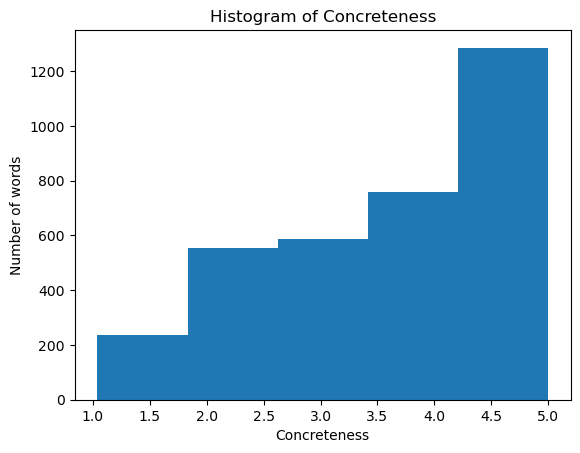

In [96]:
#Plotting
dispList = dispList.replace("",'NaN')
dispList = dispList.astype({'Concreteness':'float','TotalFreq':'float','Comprehension_AoA':'float','Production_AoA':'float'})
plt.hist(dispList['Concreteness'],5)
plt.xlabel('Concreteness')
plt.ylabel('Number of words')
plt.title('Histogram of Concreteness')
plt.savefig('plots/Soderstrom/concreteness.png')

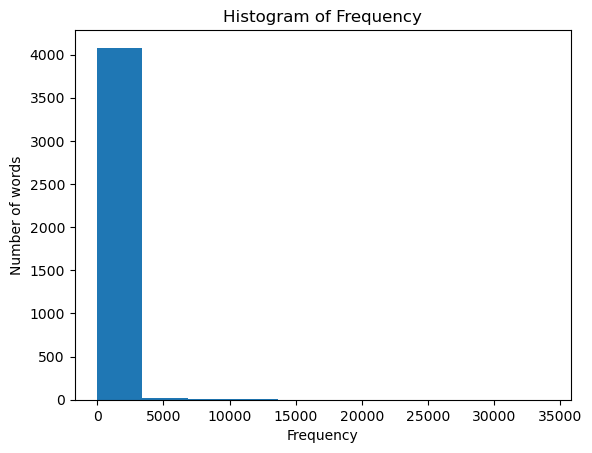

In [97]:
plt.hist(dispList['TotalFreq'])
plt.xlabel('Frequency')
plt.ylabel('Number of words')
plt.title('Histogram of Frequency')
plt.savefig('plots/Soderstrom/frequency.png')

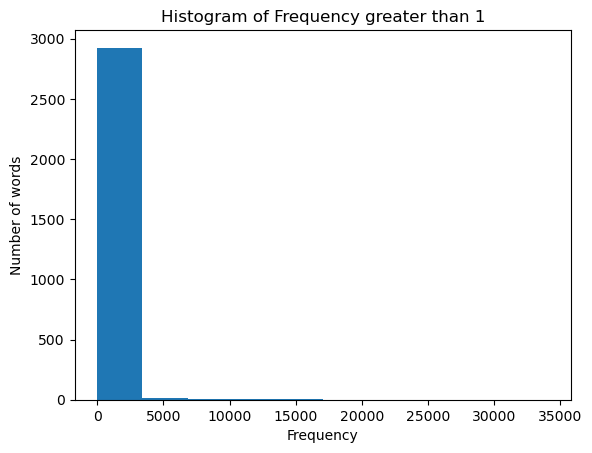

In [98]:
freq_no1 = dispList[dispList['TotalFreq']>1]
plt.hist(freq_no1['TotalFreq'])
plt.xlabel('Frequency')
plt.ylabel('Number of words')
plt.title('Histogram of Frequency greater than 1')
plt.savefig('plots/Soderstrom/frequency_no1.png')

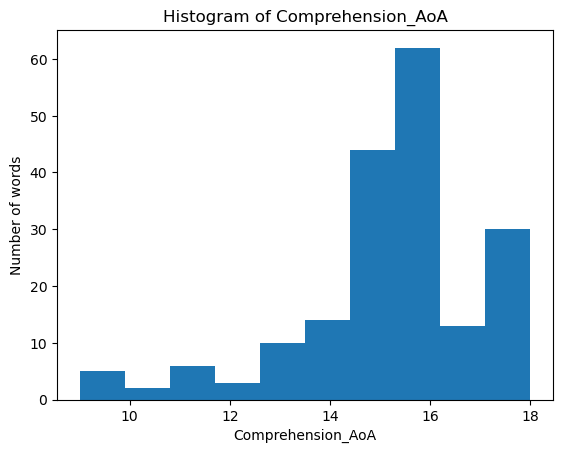

In [99]:
plt.hist(dispList['Comprehension_AoA'])
plt.xlabel('Comprehension_AoA')
plt.ylabel('Number of words')
plt.title('Histogram of Comprehension_AoA')
plt.savefig('plots/Soderstrom/comprehension_AoA.png')

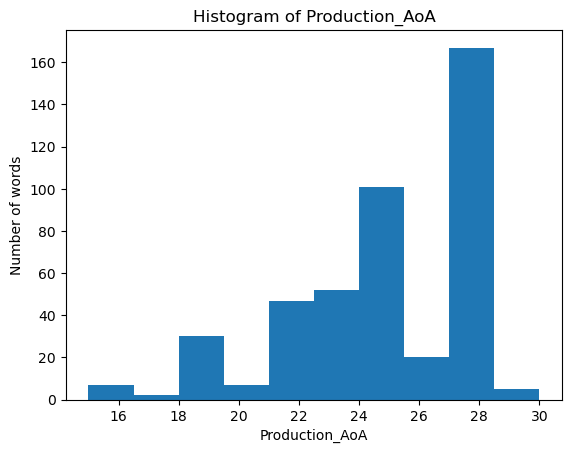

In [100]:
plt.hist(dispList['Production_AoA'])
plt.xlabel('Production_AoA')
plt.ylabel('Number of words')
plt.title('Histogram of Production_AoA')
plt.savefig('plots/Soderstrom/production_AoA.png')

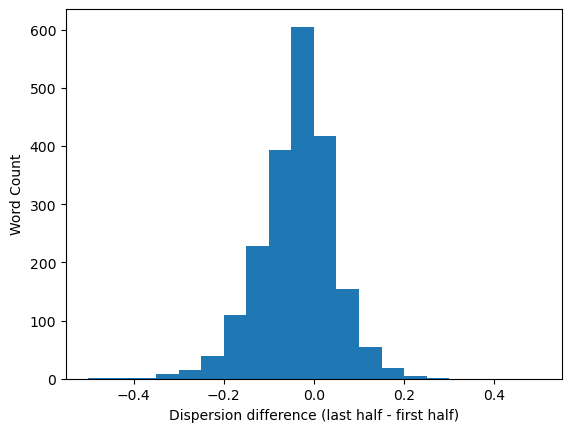

In [106]:
#Dispersion split-half differences
cutoff = round(df_sessions.shape[0]/2)
firsthalf= df_sessions.iloc[:cutoff]
secondhalf= df_sessions.iloc[cutoff:]

for i,col in firsthalf.items():
    if (col.sum()==0) or (secondhalf.loc[:,i].sum()==0):
        #print(i)
        firsthalf = firsthalf.drop(i, axis=1)
        secondhalf = secondhalf.drop(i, axis=1)

firsthalfDisp = find_DPNorm(firsthalf)
secondhalfDisp = find_DPNorm(secondhalf)

diff = np.array(secondhalfDisp)-np.array(firsthalfDisp)

plt.hist(diff, bins=20,range=(-0.5,0.5))
plt.xlabel('Dispersion difference (last half - first half)')
plt.ylabel('Word Count')
plt.savefig('plots/Lara/split_half_diff.png')

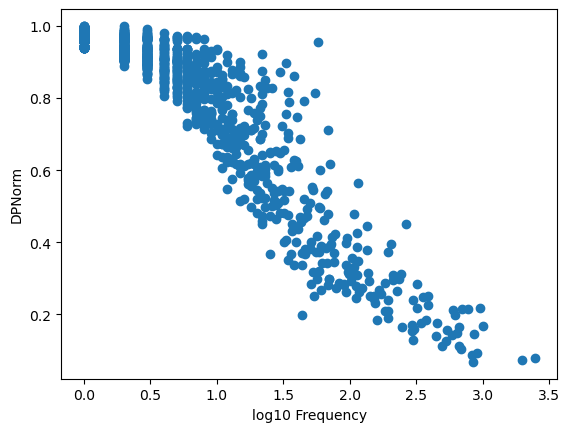

In [15]:
#Logging & Correlation
dispList['log10_frequency'] = np.log10(dispList['TotalFreq'])
dispList['log10_concreteness'] = np.log10(dispList['Concreteness'])
dispList['log10_comprehension'] = np.log10(dispList['Comprehension_AoA'])
dispList['log10_production'] = np.log10(dispList['Production_AoA'])
dispList
loggedList = dispList[["log10_frequency", "log10_concreteness", 'log10_comprehension','log10_production','DPNorm']]

plt.scatter(loggedList['log10_frequency'], loggedList['DPNorm'])
plt.xlabel('log10 Frequency')
plt.ylabel('DPNorm')
plt.savefig('plots/Soderstrom/loggedFreq_DPNorm.png')

In [16]:
#Dispersion high (top 10 frequent words)
top10 = dispList.nlargest(10,'TotalFreq')
print(top10[['Words','TotalFreq','DPNorm']])

     Words  TotalFreq    DPNorm
1289   you     2461.0  0.078869
75      be     1982.0  0.073247
581     it      995.0  0.166531
537     hm      947.0  0.218054
465     go      906.0  0.092118
566      i      855.0  0.144903
1098  that      848.0  0.068037
1132    to      827.0  0.087916
16      ah      767.0  0.213845
1099   the      699.0  0.213907


In [17]:
#Dispersion mid (10 mid-frequency words)
mid10 = dispList.sort_values(by=['TotalFreq'])
#print(mid10.values[mid10['Words'] == 'ball'])
mid10 = mid10[3830:3840]
print(mid10[['Words','TotalFreq','DPNorm']])

Empty DataFrame
Columns: [Words, TotalFreq, DPNorm]
Index: []


In [18]:
#Dispersion low (10 least frequent words)
bottom10 = dispList.nsmallest(10,'TotalFreq')
print(bottom10[['Words','TotalFreq','DPNorm']])

         Words  TotalFreq    DPNorm
4   absolutely        1.0  0.984850
6       across        1.0  0.964084
7     actually        1.0  0.961740
10     address        1.0  0.973256
14     against        1.0  0.964084
26    although        1.0  0.985829
28     amazing        1.0  0.961740
31       annoy        1.0  0.965759
33      answer        1.0  0.978667
38    anywhere        1.0  0.980290


/var/folders/2b/cx2sl931615g87qtj1jpfdqh0000gn/T/ipykernel_14223/1575995002.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = dispList.corr()


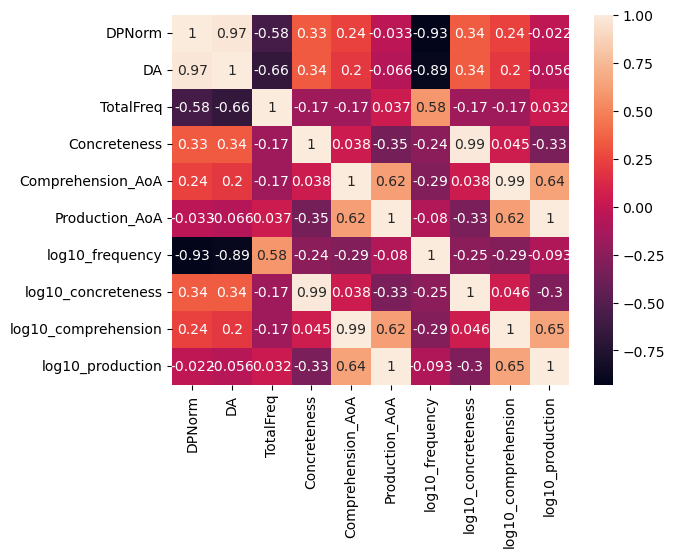

In [19]:
corr_matrix = dispList.corr()
corr_matrix
sn.heatmap(corr_matrix, annot=True)
plt.savefig('plots/Soderstrom/corr.png')

corr_matrix_logged = loggedList.corr()
corr_matrix_logged
sn.heatmap(corr_matrix_logged, annot=True)
plt.savefig('plots/Lara/corr_logged.png')

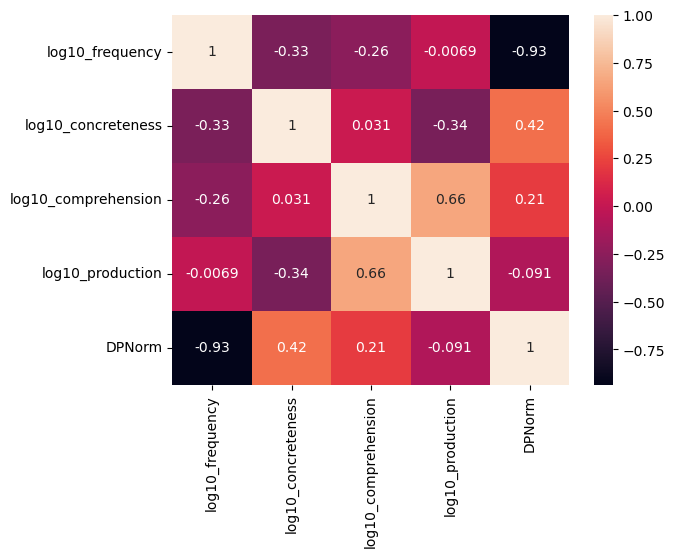

In [20]:
dispList_no1 = dispList[dispList['TotalFreq'] > 1]

loggedList_no1 = dispList_no1[["log10_frequency", "log10_concreteness", 'log10_comprehension','log10_production','DPNorm']]
corr_matrix_logged_no1 = loggedList_no1.corr()
corr_matrix_logged_no1
sn.heatmap(corr_matrix_logged_no1, annot=True)
plt.savefig('plots/Soderstrom/corr_no1.png')

In [29]:
# Ordinary Least Squares (OLS) model
modelList = dispList.dropna()
model = ols('Comprehension_AoA ~ C(TotalFreq + Concreteness)', data=modelList).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(TotalFreq + Concreteness),635.062121,145.0,1.695383,0.090971
Residual,49.083333,19.0,NaN,NaN


In [30]:
model = ols('Comprehension_AoA ~ C(TotalFreq + Concreteness + DPNorm)', data=modelList).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(TotalFreq + Concreteness + DPNorm),679.645455,163.0,0.926579,0.699594
Residual,4.500000,1.0,NaN,NaN


In [41]:
model = ols('DPNorm ~ C(log10_comprehension)', data=modelList).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(log10_comprehension),0.929024,9.0,2.177968,0.026339
Residual,7.346230,155.0,NaN,NaN


In [42]:
model = ols('DPNorm ~ C(log10_production)', data=modelList).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(log10_production),0.802489,13.0,1.247359,0.251598
Residual,7.472764,151.0,NaN,NaN
